<a href="https://colab.research.google.com/github/omisonawane619os/Seoul-Bike-Demand-Analysis-Bigdata/blob/main/Bigdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install required libraries (most are preinstalled, but safe to run)
!pip install seaborn scikit-learn


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn Modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Algorithms
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import classification_report, accuracy_score, silhouette_score

# Colab file upload
from google.colab import files

# Plot settings
sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})


In [8]:
# Upload CSV file from your computer
uploaded = files.upload()

# Automatically get uploaded filename
csv_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {csv_filename}")


Saving SeoulBikeData.csv to SeoulBikeData.csv
Uploaded file: SeoulBikeData.csv


In [9]:
def load_and_clean_data(filepath):
    df = pd.read_csv(filepath, encoding='latin1')

    # Rename columns
    df.columns = [
        'Date', 'Rented_Bike_Count', 'Hour', 'Temperature', 'Humidity',
        'Wind_Speed', 'Visibility', 'Dew_Point_Temp', 'Solar_Radiation',
        'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning_Day'
    ]

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    # Feature Engineering
    df['Month'] = df['Date'].dt.month
    df['Day_of_Week'] = df['Date'].dt.day_name()
    df['Is_Weekend'] = df['Date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

    print(f"Data Loaded Successfully. Shape: {df.shape}")
    return df


In [10]:
def perform_eda(df):
    print("Starting EDA...")

    # 1. Distribution
    plt.figure(figsize=(10,6))
    sns.histplot(df['Rented_Bike_Count'], bins=30, kde=True)
    plt.title('Distribution of Rented Bike Count')
    plt.savefig('eda_distribution.png')
    plt.show()

    # 2. Hourly Demand
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Hour', y='Rented_Bike_Count', data=df)
    plt.title('Hourly Bike Demand')
    plt.show()

    # 3. Seasonal Impact
    plt.figure(figsize=(10,6))
    sns.barplot(x='Seasons', y='Rented_Bike_Count', data=df, errorbar=None)
    plt.title('Average Rentals by Season')
    plt.show()

    # 4. Correlation Heatmap
    plt.figure(figsize=(12,10))
    corr = df.select_dtypes(include=np.number).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # 5. Temperature vs Rentals
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='Temperature', y='Rented_Bike_Count', hue='Seasons', data=df)
    plt.title('Temperature vs Bike Rentals')
    plt.show()


In [11]:
def perform_clustering(df):
    X_cluster = df[['Hour', 'Rented_Bike_Count']]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['Cluster_Label'] = kmeans.fit_predict(X_scaled)

    score = silhouette_score(X_scaled, df['Cluster_Label'])
    print(f"Silhouette Score: {score:.3f}")

    plt.figure(figsize=(10,6))
    sns.scatterplot(x='Hour', y='Rented_Bike_Count',
                    hue='Cluster_Label', data=df)
    plt.title('K-Means Clustering')
    plt.show()

    return df


In [12]:
def prepare_classification_target(df):
    bins = [-1, 300, 1000, float('inf')]
    labels = ['Low', 'Medium', 'High']

    df['Demand_Level'] = pd.cut(df['Rented_Bike_Count'], bins=bins, labels=labels)

    drop_cols = ['Rented_Bike_Count', 'Date', 'Cluster_Label']
    df_model = df.drop(columns=drop_cols)

    return df_model


In [13]:
def train_and_evaluate_models(df):
    X = df.drop('Demand_Level', axis=1)
    y = df['Demand_Level']

    categorical_cols = ['Seasons', 'Holiday', 'Functioning_Day', 'Day_of_Week']
    numerical_cols = [c for c in X.columns if c not in categorical_cols]

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    for name, model in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        acc = accuracy_score(y_test, preds)
        print(f"{name} Accuracy: {acc:.4f}")


In [14]:
def perform_grid_search(df):
    X = df.drop('Demand_Level', axis=1)
    y = df['Demand_Level']

    categorical_cols = ['Seasons', 'Holiday', 'Functioning_Day', 'Day_of_Week']
    numerical_cols = [c for c in X.columns if c not in categorical_cols]

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20]
    }

    grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
    grid.fit(X, y)

    print("Best Params:", grid.best_params_)
    print("Best CV Score:", grid.best_score_)


In [15]:
df = load_and_clean_data(csv_filename)

Data Loaded Successfully. Shape: (8760, 17)


Starting EDA...


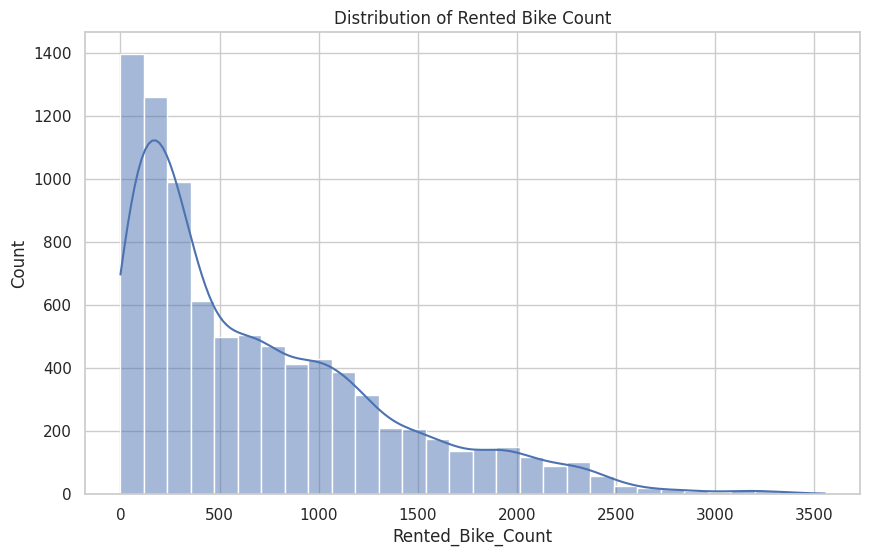

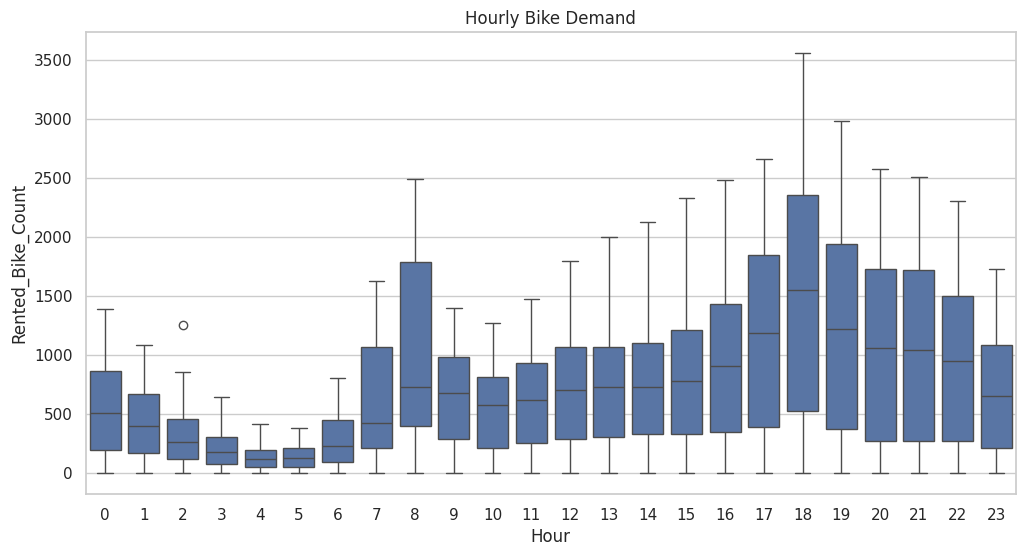

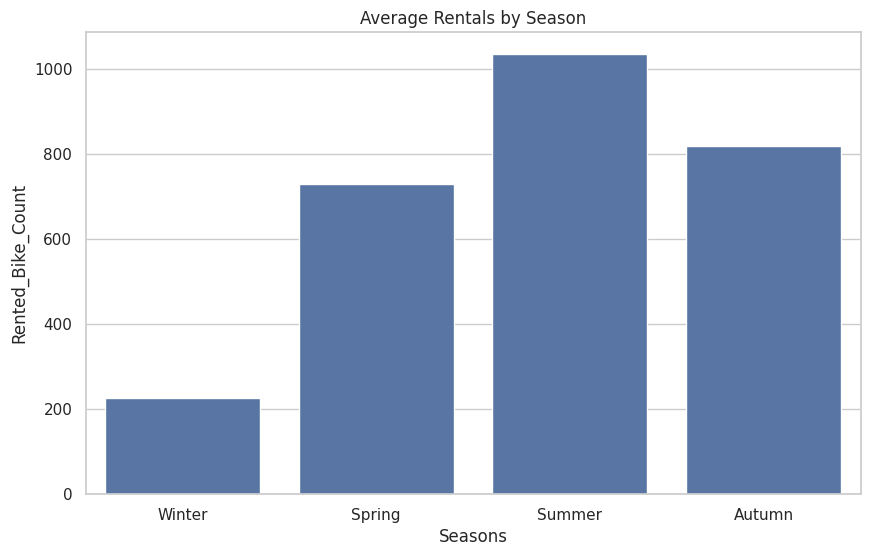

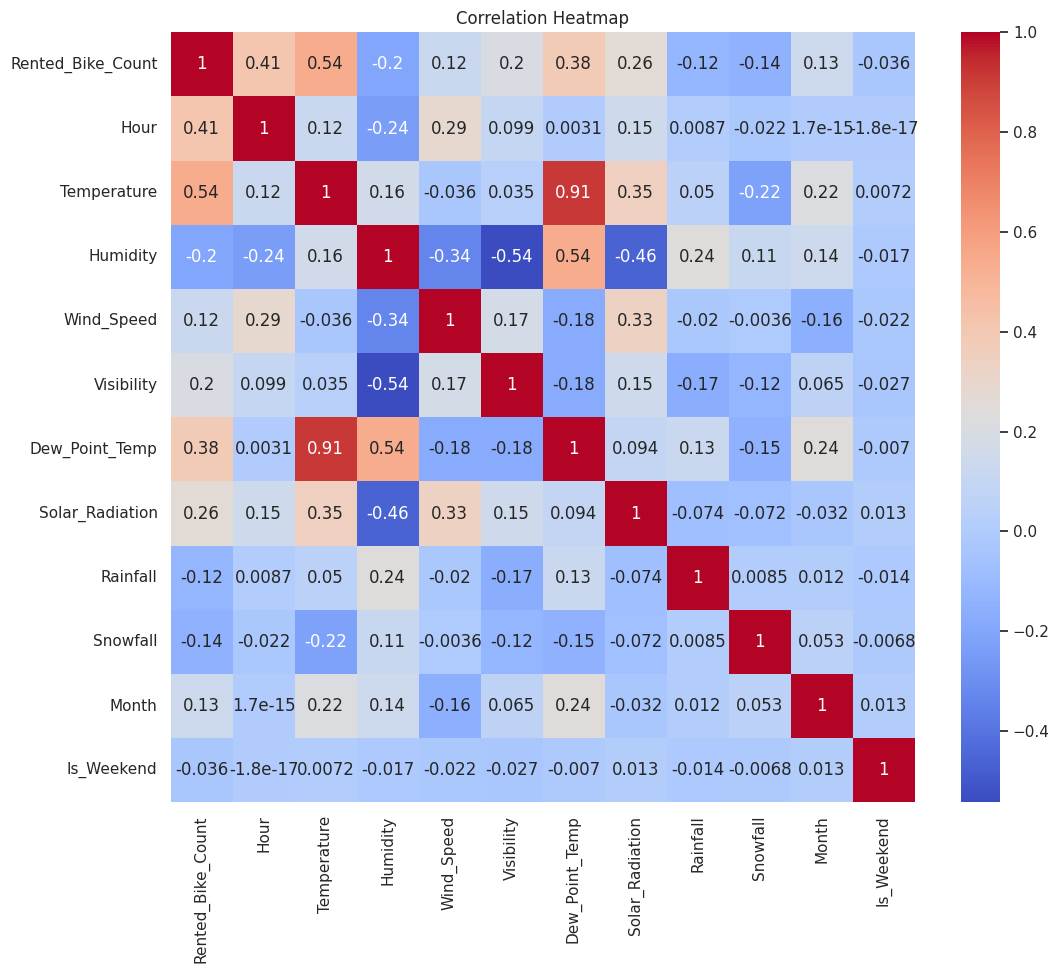

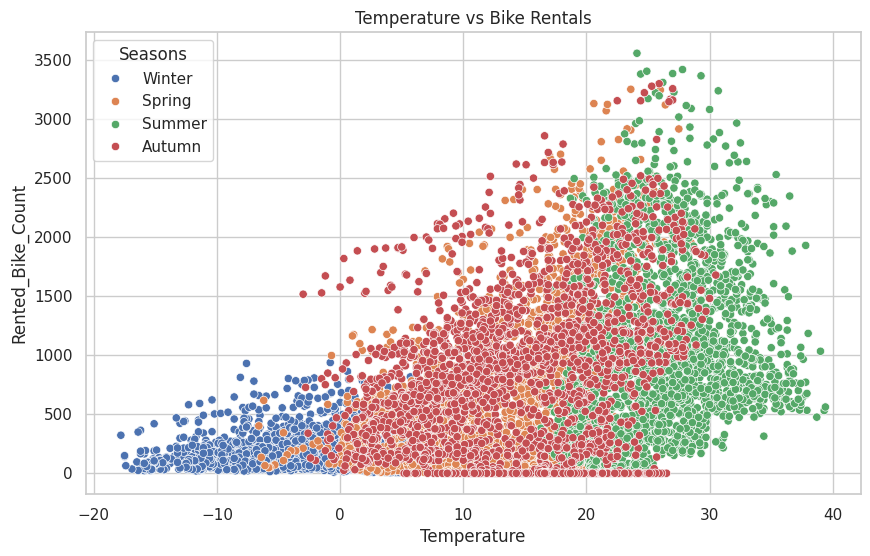

In [16]:
perform_eda(df)

Silhouette Score: 0.443


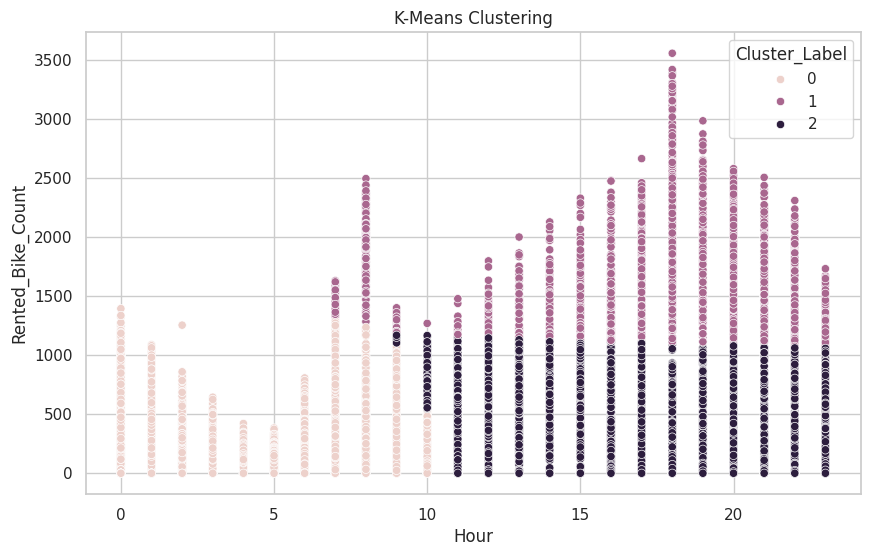

In [17]:
df = perform_clustering(df)

In [18]:
df_class = prepare_classification_target(df)

In [19]:
train_and_evaluate_models(df_class)

Logistic Regression Accuracy: 0.7009
Random Forest Accuracy: 0.8830
SVM Accuracy: 0.7934
KNN Accuracy: 0.7608
Gradient Boosting Accuracy: 0.8602


In [20]:
perform_grid_search(df_class)

Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best CV Score: 0.48698630136986304
